# Deep Learning Models Explainability

TODO short introduction

# Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system. 

In [1]:
import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import torch
import csv
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import fsspec
import zarr
import os
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from tqdm import tqdm
import gc

# Access Datacube

Let's open the dataset with xarray

In [2]:
# uncomment the lines if you download the dataset locally
# !wget -O dataset_greece.nc https://zenodo.org/record/4943354/files/dataset_greece.nc?download=1
# ds = xr.open_dataset('./dataset_greece.nc')

# comment out the following two lines if you want to access the dataset locally
url = 'https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/uc3cube.zarr'
ds = xr.open_zarr(fsspec.get_mapper(url), consolidated=True)


We see that the dataset has x,y and time dimensions.

More specifically it contains 4314 days (from 06/03/2009 to 06/12/2020) of 700x562 rasters

Dynamic variables like the `burned_areas` have all three dimensions, while static variables like `clc_2012` misses the temporal component and only has x, y dimensions.

# Load pretrained models

Pytorch lightning checkpoints are on `saved_models` directory.

The code for the models is in the `src` directory.

In [3]:
from src.greece_fire_models import CNN_fire_model, LSTM_fire_model, ConvLSTM_fire_model

In [4]:
dynamic_features = ['Fpar_500m', 'Lai_500m', 'LST_Day_1km', 'LST_Night_1km', '1 km 16 days NDVI', '1 km 16 days EVI', 'era5_max_u10', 'era5_max_v10', 'era5_max_t2m', 'era5_max_tp', 'era5_min_u10', 'era5_min_v10', 'era5_min_t2m']
static_features= ['dem_mean', 'aspect_mean', 'slope_mean', 'roads_density_2020', 'population_density']
best_settings = {
    'lstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 64,  'lstm_layers':1, 'attention':False},
    'cnn' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16},
    'convlstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16,  'lstm_layers':1},

}

In [5]:
model = 'lstm'
lstm = LSTM_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/lstm.ckpt')

/home/jupyter-iprapas/.virtualenvs/python38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/jupyter-iprapas/.virtualenvs/python38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
model = 'cnn'
cnn = CNN_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/cnn.ckpt')

In [7]:
model = 'convlstm'
convlstm = ConvLSTM_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/convlstm.ckpt')

# TODO analysis on point

We select a day from the test set (year 2020) that there was a big fire

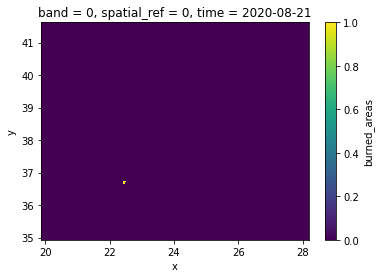

In [8]:
ds.isel(time=4186)['burned_areas'].plot()

Now let's explain our model's predictions in the place that the fire occured.

In [9]:
example = ds.sel(x=22.43, y=36.72, time='2020-08-21',method="nearest")

x = np.where(ds['x'].values==example['x'].values)[0][0]
y = np.where(ds['y'].values==example['y'].values)[0][0] 
time = np.where(ds['time'].values==example['time'].values)[0][0]

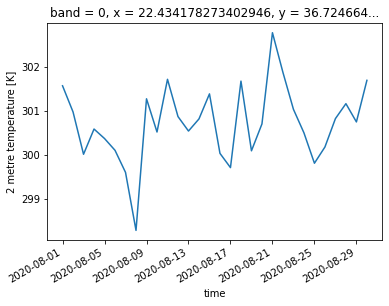

In [10]:
ds.sel(x=22.43, y=36.72, method='nearest').sel(time=slice('2020-08-01', '2020-08-30')).era5_max_t2m.plot()

In [11]:
from src.greece_fire_dataset import get_pixel_feature_vector



In [12]:
ds

<xarray.Dataset>
Dimensions:                  (time: 4314, x: 700, y: 562)
Coordinates:
    band                     int64 ...
    spatial_ref              (time) int64 dask.array<chunksize=(288,), meta=np.ndarray>
  * time                     (time) datetime64[ms] 2009-03-06 ... 2020-12-26
  * x                        (x) float64 19.86 19.87 19.89 ... 28.16 28.17 28.18
  * y                        (y) float64 41.62 41.61 41.59 ... 34.96 34.95 34.94
Data variables: (12/58)
    1 km 16 days EVI         (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days NDVI        (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days VI Quality  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_500m                  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_QC_500m               (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    FparExtra_QC             (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ...                       ...
    population_density_2020  (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    roads_density_2020       (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_max                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_mean               (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_min                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_std                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [13]:
example = ds.sel(x=22.43, y=36.72, time='2020-08-21',method="nearest")


x = np.where(ds['x'].values==example['x'].values)[0][0]
y = np.where(ds['y'].values==example['y'].values)[0][0] 
t = np.where(ds['time'].values==example['time'].values)[0][0]


# XAI TODO

In [16]:
for model, access_mode, patch_size, lag in (lstm, 'temporal', 0 , 10), (cnn, 'spatial', 25, 1), (convlstm, 'spatiotemporal', 25, 10):
    dynamic, static = get_pixel_feature_vector(ds, t=t, x=x, y=y, access_mode=access_mode, patch_size=patch_size, lag=lag,
                             dynamic_features=dynamic_features,
                             static_features=static_features, nan_fill=-1.0, override_whole=False)
    print(dynamic.shape, static.shape)
    dynamic = torch.tensor(dynamic).unsqueeze(dim=0)
    static = torch.tensor(static).unsqueeze(dim=0)
    model.eval()
    if access_mode == 'spatial':
        dynamic = dynamic.float()
        static = static.float()
        inputs = torch.cat([dynamic, static], dim=1)
    if access_mode == 'temporal':
        bsize, timesteps, _ = dynamic.shape
        static = static.unsqueeze(dim=1)
        repeat_list = [1 for _ in range(static.dim())]
        repeat_list[1] = timesteps
        static = static.repeat(repeat_list)
        inputs = torch.cat([dynamic, static], dim=2).float()
    if access_mode == 'spatiotemporal':
        bsize, timesteps, _, _, _ = dynamic.shape
        static = static.unsqueeze(dim=1)
        repeat_list = [1 for _ in range(static.dim())]
        repeat_list[1] = timesteps
        static = static.repeat(repeat_list)
        inputs = torch.cat([dynamic, static], dim=2).float()
    logits = model(inputs)
    preds_proba = torch.exp(logits)[:, 1]
    print(f'{access_mode}: {preds_proba}')

(10, 13) (5,)
temporal: tensor([0.8138], grad_fn=<SelectBackward>)
(13, 25, 25) (5, 25, 25)
spatial: tensor([0.2863], grad_fn=<SelectBackward>)
(10, 13, 25, 25) (5, 25, 25)
spatiotemporal: tensor([0.6255], grad_fn=<SelectBackward>)


# Discussion

**TODO**

# Acknowledgements

Research funded by the EU H2020 DeepCube ’Explainable AI pipelines for big Copernicus data’.


Notebook Authors: *TODO*